# Pixel CNN

This block

- imports all modules/libraries needed
- contains a function for a learning rate scheduler (if needed)
- reads in SMILES strings and creates a list
- featurizes via the SmilesTo Image featurizer from Deepchem (https://github.com/deepchem/deepchem)
- Four channel image used for featurization
  * Atomic numbers + bonds
  * partial charges
  * valence
  * hybridization

In [1]:
!pip install deepchem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 23.3 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
import deepchem as dc
import time
from rdkit import Chem
from functools import partial
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem, Draw
from sklearn.model_selection import train_test_split

def exp_decay(lr0,s):
    def exp_decay_fcn(epoch):
        return lr0*0.1**(epoch/s)
    return exp_decay_fcn

#df = pd.read_csv("392-azo.csv")
#df = pd.read_csv("212-azo.csv")
#df = pd.read_csv("604-azo.csv")
#df = pd.read_csv(r"/content/sample_data/621-azo.csv")
df = pd.read_csv(r"/content/sample_data/6731-azo.csv")

Xa = [""]*len(df)
w = [""]*len(df)
i=0
for name in df["SMILES"]:
    Xa[i]=name
    w[i]=1.0
    i += 1
Xa = list(Xa)
w=list(w)

#===========================================================================================
#featurizer

featurizer=dc.feat.SmilesToImage(img_spec="engd")
featname="SmilesToImage"

f = featurizer.featurize(Xa)
print("Number of features and datapoints: ",f.shape)

#===========================================================================================
print("featurization done with: ",featname)

# set npp for how many points in the dataset, len(df) for whole dataset
nnp= len(df)

#set y to lambdamax
y = df["Lmax"]

#set dataset and split

dataset = dc.data.NumpyDataset(X=f[:nnp,:,:,:], y=y[:nnp], ids=Xa[:nnp], w=w[:nnp])

Number of features and datapoints:  (6731, 80, 80, 4)
featurization done with:  SmilesToImage


## Scales images

In [4]:
smallest = dataset.X.min()
biggest = dataset.X.max()

print(f"Minimum value is: {smallest}")
print(f"Maximum value is: {biggest}")

new_inputs = []
for pic in dataset.X:
    pic = ((pic - smallest) * (1/(biggest-smallest)) * 255).astype('uint8')
    new_inputs.append(pic)

new_array = np.array(new_inputs)
print(f"New scaled array created: {new_array.shape}")
smallest = new_array.min()
biggest = new_array.max()

print(f"Minimum value is: {smallest}")
print(f"Maximum value is: {biggest}")

Minimum value is: -0.8723551034927368
Maximum value is: 53.0
New scaled array created: (6731, 80, 80, 4)
Minimum value is: 0
Maximum value is: 255


## Define the Pixel CNN using TensorFlow distributions

In [5]:
embsize=128
dropout_rate = 0.3

dist = tfp.distributions.PixelCNN(image_shape = (80,80,4), num_resnet = 1,
                                 num_hierarchies = 2, num_filters  = 32, num_logistic_mix = 5,
                                 dropout_p = dropout_rate)

image_input = tf.keras.layers.Input(shape = (80,80,4))
log_proba = dist.log_prob(image_input)

pixelcnn = tf.keras.models.Model(inputs = image_input, outputs = log_proba)
pixelcnn.add_loss(-tf.reduce_mean(log_proba))

print("Pixel CNN built.")

Pixel CNN built.


## Train the Pixel CNN

In [6]:
pixelcnn.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001))

pixelcnn.fit(new_array, epochs = 50, batch_size = 128,verbose = True)

Epoch 1/50
53/53 [==============================] - 106s 1s/step - loss: 301160.5000
Epoch 2/50
53/53 [==============================] - 70s 1s/step - loss: 162652.9844
Epoch 3/50
53/53 [==============================] - 70s 1s/step - loss: 106958.9062
Epoch 4/50
53/53 [==============================] - 70s 1s/step - loss: 81002.7266
Epoch 5/50
53/53 [==============================] - 70s 1s/step - loss: 65795.0000
Epoch 6/50
53/53 [==============================] - 70s 1s/step - loss: 66011.8750
Epoch 7/50
53/53 [==============================] - 70s 1s/step - loss: 62152.5195
Epoch 8/50
53/53 [==============================] - 70s 1s/step - loss: 51539.7734
Epoch 9/50
53/53 [==============================] - 70s 1s/step - loss: 51004.2812
Epoch 10/50
53/53 [==============================] - 70s 1s/step - loss: 48576.7227
Epoch 11/50
53/53 [==============================] - 70s 1s/step - loss: 51093.6680
Epoch 12/50
53/53 [==============================] - 70s 1s/step - loss: 41012.29

## Plot generated images

- use the generator to make a couple of images
- rescales pixels to original range

(2, 80, 80, 4)


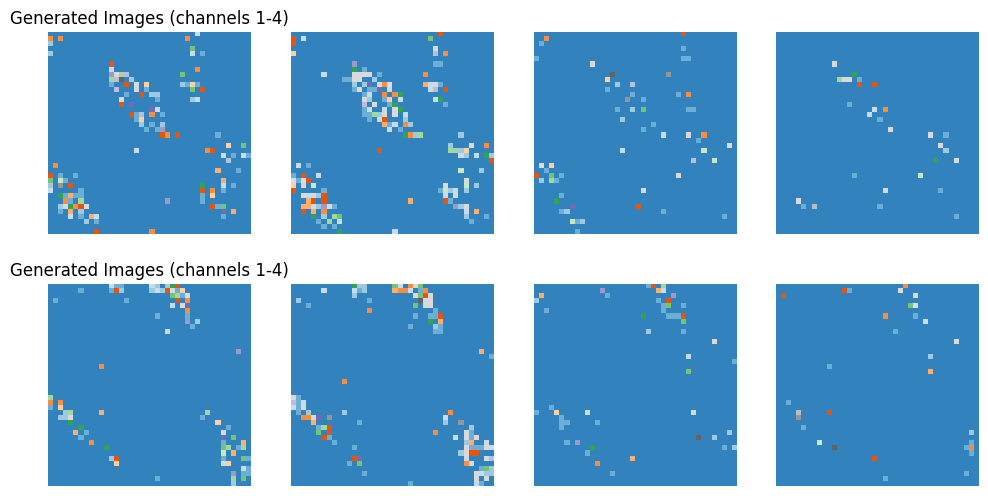

In [7]:
#load a model

recons_embed = dist.sample(2).numpy()
print(recons_embed.shape)

from matplotlib import pyplot as plt
from scipy import ndimage

cmap="tab20c"

def new_images(image,channel):
    recons = image[:,:,channel] #last number cycles through channels 0-3
    recons = (biggest-smallest)*recons/255 + smallest
    rot = ndimage.rotate(recons, 0)
    rot  = rot[20:60, 20:60]
    return rot

newimages=[]
newimages2=[]
for i in range(4):
    new1 = new_images(image=recons_embed[0],channel=i)
    newimages.append(new1)
    new1 = new_images(image=recons_embed[1],channel=i)
    newimages2.append(new1)

#can insert scaling code here

fig, arrax = plt.subplots(2, 4, figsize=(12,6))
for i in range(4):
    arrax[0,i].imshow(newimages[i],cmap=cmap)
    arrax[1,i].imshow(newimages2[i],cmap=cmap)
    arrax[0,i].axis("off")
    arrax[1,i].axis("off")
arrax[0,0].set_title("Generated Images (channels 1-4)")
arrax[1,0].set_title("Generated Images (channels 1-4)")

plt.show()

## Save PixelCNN

In [8]:
checkpoint = tf.train.Checkpoint(model=pixelcnn)
checkpoint.save(file_prefix='6731_April4_50epcs')

print("Saved model")

Saved model


## Load and restart training on the PixelCNN

In [ ]:
epcs = 100

pixelcnn.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001))
pixelcnn.fit(new_array, epochs = epcs+100, batch_size = 64, verbose = True, initial_epoch = epcs)